In [ ]:
!nvidia-smi

Sun Sep 25 14:37:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cp -r /content/drive/MyDrive/20210312 .

In [ ]:
# !cp -r 20210312 /content/drive/MyDrive/20210312 

In [ ]:
!cp -r /content/drive/MyDrive/20210312-test .

In [ ]:
!cp -r /content/drive/MyDrive/CASE22_code .

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.9 MB/s 


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.0 MB 4.7 MB/s 
     |████████████████████████████████| 120 kB 72.5 MB/s 


In [ ]:
!pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-g2xz7q0y
  Running command git clone -q https://github.com/huggingface/accelerate /tmp/pip-req-build-g2xz7q0y
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for accelerate: filename=accelerate-0.13.0.dev0-py3-none-any.whl size=148627 sha256=52771283943a9339f061b00b574b6ab1e7d01466be02506fc3a0325f7f4e5b79
  Stored in directory: /tmp/pip-ephem-wheel-cache-l1tig4yo/wheels/81/c1/23/6068c1115888b4dd7da88f966c002c30840985c047f6cc1653
Successfully built accelerate


In [ ]:
!git clone https://github.com/huggingface/transformers.git 

Cloning into 'transformers'...
remote: Enumerating objects: 110529, done.
remote: Counting objects: 100% (640/640), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 110529 (delta 372), reused 424 (delta 253), pack-reused 109889
Receiving objects: 100% (110529/110529), 103.05 MiB | 27.87 MiB/s, done.
Resolving deltas: 100% (81741/81741), done.


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 67.4 MB/s 
     |████████████████████████████████| 115 kB 65.5 MB/s 
     |████████████████████████████████| 127 kB 65.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=f78e46a785b88606ecaabdce1d7368d544e58f20cd87d583a3eac2514cb72a93
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
import io
import os
import json
import torch
import random

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
# from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd
import numpy as np

from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          AutoTokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          AutoModelForTokenClassification)

In [ ]:
set_seed(123);
random.seed(123);
split_ratio = 0.10

In [ ]:
path = '20210312/subtask4-token'
split = 'combined'
data = pd.read_csv('{}/{}-train.txt'.format(path, split), sep='\t', encoding='unicode_escape')
labels_to_ids = {k: v for v, k in enumerate(data.O.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.O.unique())}
label_list = list(labels_to_ids.keys())

sentences = []
vals= []
s = []
with open('{}/{}-train.txt'.format(path, split),'r') as fp:
  for i, d in enumerate(fp):
    if d.isspace():
      if random.random() < split_ratio:
        vals.append(s)
      else:
        sentences.append(s)
      s = []
      continue
    o = d.split('\t')
    s.append((o[0],o[1].replace('\n','')))
sentences.append(s)
my_dataset = [list(zip(*sentences[i])) for i in range(len(sentences))]
my_val_dataset = [list(zip(*vals[i])) for i in range(len(vals))]
my_datadict = []#{'tokens': [],
              #"ner_tags": []}
for d in my_dataset:
  if len(d) == 2:
    my_datadict.append({'tokens':d[0],'ner_tags':d[1]})
    # my_datadict['tokens'].append(d[0])
    # my_datadict['ner_tags'].append(d[1])
  else:
    continue
# my_datadict['tokens'] = tuple(my_datadict['tokens'])
# my_datadict['ner_tags'] = tuple(my_datadict['ner_tags'])
with open(os.path.join(path, 'CASE22_combined.json'),'w') as fp:
  for d in my_datadict:
    print(json.dumps(d), file=fp)
with open(os.path.join(path, 'CASE22_combined_labels.json'),'w') as fp:
  json.dump({'labels_to_ids':labels_to_ids, 'ids_to_labels':ids_to_labels}, fp)

my_val_datadict = []#{'tokens': [],
              #"ner_tags": []}
for d in my_val_dataset:
  if len(d) == 2:
    my_val_datadict.append({'tokens':d[0],'ner_tags':d[1]})
    # my_val_datadict['tokens'].append(d[0])
    # my_val_datadict['ner_tags'].append(d[1])
  else:
    continue
# my_val_datadict['tokens'] = np.array(my_val_datadict['tokens'])
# my_val_datadict['ner_tags'] = tuple(my_val_datadict['ner_tags'])
with open(os.path.join(path, 'CASE22_val_combined.json'),'w') as fp:
    for d in my_val_datadict:
      print(json.dumps(d), file=fp)
with open(os.path.join(path, 'CASE22_val_combined_labels.json'),'w') as fp:
  json.dump({'labels_to_ids':labels_to_ids, 'ids_to_labels':ids_to_labels}, fp)

In [ ]:
lens = []
for d in my_dataset:
  if len(d) == 2:
    lens.append(len(d[0]))
print(max(lens), min(lens), sum(lens)/len(lens))

731 7 129.33893919793013


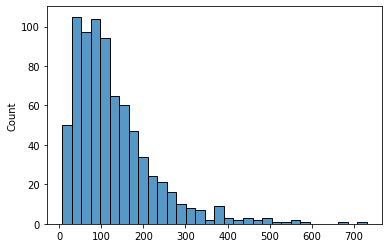

In [ ]:
import seaborn as sns
sns.histplot(lens)

In [ ]:
%cd /content

/content


In [ ]:
!pip install evaluate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 


In [ ]:
from datasets import load_dataset
# dataset = load_dataset("json", data_files={"train": base_url + "train-v1.1.json", "validation": base_url + "dev-v1.1.json"}, field="data")
dataset = load_dataset("json", data_files={"train": os.path.join(path, 'CASE22_combined.json'), "validation":os.path.join(path, 'CASE22_val_combined.json')})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-92c7e9b6c6ba8e87/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
!pip install huggingface_hub


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!huggingface-cli login



        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [ ]:
dataset.push_to_hub("peratham/CASE22subtask4")

In [ ]:
# %env TASK_NAME=ner

# !python transformers/examples/pytorch/token-classification/run_ner_no_trainer.py \
#   --model_name_or_path bigscience/bloom-1b1 \
#   --train_file 20210312/subtask4-token/CASE22_combined.json \
#   --validation_file 20210312/subtask4-token/CASE22_val_combined.json \
#   --task_name $TASK_NAME \
#   --max_length 300 \
#   --per_device_train_batch_size 12 \
#   --learning_rate 1e-4 \
#   --num_train_epochs 30 \
#   --output_dir ./CASE22_subtask4_bloom1b1/

In [ ]:
# %env TASK_NAME=ner

# !python transformers/examples/pytorch/token-classification/run_ner.py \
#   --model_name_or_path bigscience/bloom-1b1 \
#   --train_file 20210312/subtask4-token/CASE22_combined.json \
#   --validation_file 20210312/subtask4-token/CASE22_val_combined.json \
#   --task_name $TASK_NAME \
#   --per_device_train_batch_size 12 \
#   --learning_rate 1e-4 \
#   --num_train_epochs 30 \
#   --do_train \
#   --do_eval \
#   --output_dir ./CASE22_subtask4_bloom1b1/